In [1]:
import numpy as np
import itertools as it
import math 
import csv
import time

import matplotlib.pyplot as plt
from sage.modules.free_module_integer import IntegerLattice
from sage.modules.free_module_integer import IntegerLattice

path = 'C:/Users/User/Documents/Учёба/ВKР/SVP/'

In [2]:
def vectors_of_group(generating_vector):
    mas_elem_of_group = []
    for element in generating_vector:
        mas_elem_of_group.append(vector(range(abs(element))))
    vectors = list(it.product(*mas_elem_of_group))
    vectors_of_group = Matrix(vectors)
    vectors_of_group = vectors_of_group.T
    return vectors_of_group

def Mod(value_vector, mod_vector):
    new_vector = []
    for i, mod in enumerate(mod_vector):
        new_vector.append(value_vector[i] % mod)
    return Matrix(new_vector)

def FPT(size_matrix, delta, g, X, G, S, p):
    dict_of_optimal_value = {}

    for row in range(size_matrix):
        for i in range(delta):
            min_x = math.inf
            min_x_without_zero =  math.inf
            min_x_first_nonzero =  math.inf
            vector_g = g[:, i]

            for x_i in X:
                vector_G = G[size_matrix-len(S):, row]*x_i
                x_i_to_the_p_power = x_i**p
                if row != 0:
                    key = (row-1, str(Mod(vector_g - vector_G, S)))          
                    if dict_of_optimal_value[key] + x_i_to_the_p_power < min_x_without_zero:
                        min_x_without_zero = dict_of_optimal_value[key] + x_i_to_the_p_power

                    if Mod(vector_G, S) == vector_g  and x_i != 0:
                        if x_i_to_the_p_power < min_x_first_nonzero:
                            min_x_first_nonzero = x_i_to_the_p_power
          
                elif row == 0:
                    if Mod(vector_G, S) == vector_g  and x_i != 0:
                        if x_i_to_the_p_power < min_x:
                            min_x = x_i_to_the_p_power
            
            if row != 0:
                if min_x_without_zero == math.inf and min_x_first_nonzero == math.inf:
                    min_x = math.inf
                else:
                    if min_x_without_zero < min_x_first_nonzero:
                        min_x = min_x_without_zero
                    else:
                        min_x = min_x_first_nonzero

            key = (row, str(vector_g))
            dict_of_optimal_value.update({key: min_x})

    return dict_of_optimal_value

In [3]:
def get_random_matrices(name_file):
    
    ifile  = open(path+name_file)
    read = csv.reader(ifile)
    
    array_strings = []
    for row in read :
        array_strings.append(row)
        
    sizes_matrix = []
    list_random_matrix = []    
    index = 0
    
    while index < len(array_strings):
        n = int(array_strings[index][0])
        index += 1
        matrix = []
        for j in range(index, index+n):    
            matrix.append(list(map(int, (array_strings)[j][0].split())))
            index += 1
        sizes_matrix.append(n)
        list_random_matrix.append(Matrix(matrix))

    return list_random_matrix

In [15]:
def run_tests(list_random_matrix, file_for_FinckePhost_time, file_for_FPT_time, p = 2):

    file_time_FPT = open(path+file_for_FPT_time, 'w')
    file_time_FinckePhost = open(path+file_for_FinckePhost_time, 'w')

    for index, matrix in enumerate(list_random_matrix):
        
        n = len(matrix[0])
        print("\n Step ", index, "\n determinant =",matrix.det(), "    size =", n)
        
# FPT-algorithm             
        start_time_FPT = time.time()
        
        S, G, Q = matrix.smith_form()
        S = vector(filter(lambda x: abs(x)>1, S.elementary_divisors()))
        g = vectors_of_group(S)
        delta = prod(S)
        X = list(range(-S[-1], S[-1]+1))

        dict_of_optimal_value = FPT(n, delta, g, X, G, S, p)
        
        end_time_FPT = time.time()

        file_time_FPT.write(str(end_time_FPT-start_time_FPT))
        file_time_FPT.write(', ')
  
        solve_key = (n-1, str(g[:, 0]))
        FPT_min = dict_of_optimal_value[solve_key]

# Fincke-Pohst-algorithm
        # Нужно транспонировать матрицу, т.к. алгоритм ищет минимум по строкам, а не по столбцам
        example_matrix = IntegerLattice(matrix.T) 
    
        start_time_FinckePhost = time.time()       
        U = example_matrix.shortest_vector(algorithm = "pari")       
        end_time_FinckePhost = time.time()
        
        file_time_FinckePhost.write(str(end_time_FinckePhost-start_time_FinckePhost))
        file_time_FinckePhost.write(', ')

        FinckePhost_min = sum([abs(element)**p for element in U])

        print("FinckePhost_min =", FinckePhost_min, "  FPT_min =", FPT_min)

        if FPT_min != FinckePhost_min:
            print("FPT_min =", FPT_min, "  FinckePhost_min =", FinckePhost_min)
            print(example_matrix)
            print(matrix)


In [5]:
def run_tests(list_random_matrix, file_for_FinckePhost_time, file_for_FPT_time, file_for_fplll_time, p = 2):

    file_time_FPT = open(path+file_for_FPT_time, 'w')
    file_time_FinckePhost = open(path+file_for_FinckePhost_time, 'w')
    file_time_fplll = open(path+file_for_fplll_time, 'w')

    for index, matrix in enumerate(list_random_matrix):
        
        n = len(matrix[0])
        print("\n Step ", index, "\n determinant =",matrix.det(), "    size =", n)
        
# FPT-algorithm             
        start_time_FPT = time.time()
        
        S, G, Q = matrix.smith_form()
        S = vector(filter(lambda x: abs(x)>1, S.elementary_divisors()))
        g = vectors_of_group(S)
        delta = prod(S)
        X = list(range(-S[-1], S[-1]+1))

        dict_of_optimal_value = FPT(n, delta, g, X, G, S, p)
        
        end_time_FPT = time.time()

        file_time_FPT.write(str(end_time_FPT-start_time_FPT))
        file_time_FPT.write(', ')
  
        solve_key = (n-1, str(g[:, 0]))
        FPT_min = dict_of_optimal_value[solve_key]

# Fincke-Pohst-algorithm ("pari")
        # Нужно транспонировать матрицу, т.к. алгоритм ищет минимум по строкам, а не по столбцам
        example_matrix = IntegerLattice(matrix.T) 
    
        start_time_FinckePhost = time.time()       
        shortest_vector = example_matrix.shortest_vector(algorithm = "pari")       
        end_time_FinckePhost = time.time()
        
        file_time_FinckePhost.write(str(end_time_FinckePhost-start_time_FinckePhost))
        file_time_FinckePhost.write(', ')

        FinckePhost_min = sum([abs(element)**p for element in shortest_vector])
        
# Fincke-Pohst-algorithm ("fplll")
    
        start_time_fplll = time.time()       
        shortest_vector_fplll = example_matrix.shortest_vector(algorithm = "fplll")       
        end_time_fplll = time.time()
        
        file_time_fplll.write(str(end_time_fplll-start_time_fplll))
        file_time_fplll.write(', ')

        fplll_min = sum([abs(element)**p for element in shortest_vector_fplll])
        
        print("fplll_min =", fplll_min, "  FPT_min =", FPT_min)
            
        if FPT_min != FinckePhost_min:
            print("FPT_min =", FPT_min, "  FinckePhost_min =", FinckePhost_min)
            print(example_matrix)
            print(matrix)
        

In [6]:
def get_time_from_file(name_file, num_same_sizes = 5):     # с шагом 5, т.к каждая размерность представлена 5ю матрицами
    ifile  = open(path+name_file)
    read = csv.reader(ifile)
    list_time = []
    for row in read :
        row.pop()    # т.к последний элемент пустая строка
        list_from_file = [float(string_time) for string_time in row]

    for index in range(0, len(list_from_file), num_same_sizes):   
        list_same_sizes = []
        for indx_matrix_same_size in range(num_same_sizes):
            list_same_sizes.append(list_from_file[index+indx_matrix_same_size]) 
        list_time.append(np.mean(list_same_sizes))
    return list_time

In [7]:
def plot_timeline(list_of_sizes_matrix, lists_times_from_diff_alg, lists_lables):
    num_lines = len(lists_lables)
    list_legends = []
    for idx in range(num_lines):
        alg, = plt.plot(list_of_sizes_matrix, lists_times_from_diff_alg[idx], label = lists_lables[idx])
        list_legends.append(alg)
    plt.legend(handles = list_legends)
    plt.xlabel("size matrix")
    plt.ylabel("time")
    plt.show()

In [26]:
list_random_matrix_det10 = get_random_matrices("matrix_size1000_det10.csv")

In [37]:
run_tests(list_random_matrix_det10, "LLL_time_det10.csv", "FPT_time_det10.csv")


 Step  0 
 determinant = 10     size = 100
LLL_min = 1   FPT_min = 1

 Step  1 
 determinant = 10     size = 100
LLL_min = 1   FPT_min = 1

 Step  2 
 determinant = 10     size = 100
LLL_min = 1   FPT_min = 1

 Step  3 
 determinant = 10     size = 200
LLL_min = 1   FPT_min = 1

 Step  4 
 determinant = 10     size = 200
LLL_min = 1   FPT_min = 1

 Step  5 
 determinant = 10     size = 200
LLL_min = 1   FPT_min = 1

 Step  6 
 determinant = 10     size = 300
LLL_min = 1   FPT_min = 1

 Step  7 
 determinant = 10     size = 300
LLL_min = 1   FPT_min = 1

 Step  8 
 determinant = 10     size = 300
LLL_min = 1   FPT_min = 1

 Step  9 
 determinant = 10     size = 400
LLL_min = 1   FPT_min = 1

 Step  10 
 determinant = 10     size = 400
LLL_min = 1   FPT_min = 1

 Step  11 
 determinant = 10     size = 400
LLL_min = 1   FPT_min = 1

 Step  12 
 determinant = 10     size = 500
LLL_min = 1   FPT_min = 1

 Step  13 
 determinant = 10     size = 500
LLL_min = 1   FPT_min = 1

 Step  14 
 det

In [7]:
list_random_matrix_det30 = get_random_matrices("matrix_size1000_det30.csv")

In [8]:
run_tests(list_random_matrix_det30, "LLL_time_det30.csv", "FPT_time_det30.csv")


 Step  0 
 determinant = 30     size = 100
LLL_min = 1   FPT_min = 1

 Step  1 
 determinant = 30     size = 100
LLL_min = 1   FPT_min = 1

 Step  2 
 determinant = 30     size = 100
LLL_min = 1   FPT_min = 1

 Step  3 
 determinant = 30     size = 200
LLL_min = 1   FPT_min = 1

 Step  4 
 determinant = 30     size = 200
LLL_min = 1   FPT_min = 1

 Step  5 
 determinant = 30     size = 200
LLL_min = 1   FPT_min = 1

 Step  6 
 determinant = 30     size = 300
LLL_min = 1   FPT_min = 1

 Step  7 
 determinant = 30     size = 300
LLL_min = 1   FPT_min = 1

 Step  8 
 determinant = 30     size = 300
LLL_min = 1   FPT_min = 1

 Step  9 
 determinant = 30     size = 400
LLL_min = 1   FPT_min = 1

 Step  10 
 determinant = 30     size = 400
LLL_min = 1   FPT_min = 1

 Step  11 
 determinant = 30     size = 400
LLL_min = 1   FPT_min = 1

 Step  12 
 determinant = 30     size = 500
LLL_min = 1   FPT_min = 1

 Step  13 
 determinant = 30     size = 500
LLL_min = 1   FPT_min = 1

 Step  14 
 det

In [13]:
list_random_matrix_det60 = get_random_matrices("matrix_size1000_det60.csv")

In [16]:
run_tests(list_random_matrix_det60, "LLL_time_det60.csv", "FPT_time_det60.csv")


 Step  0 
 determinant = 60     size = 100
FinckePhost_min = 2   FPT_min = 2

 Step  1 
 determinant = 60     size = 100
FinckePhost_min = 1   FPT_min = 1

 Step  2 
 determinant = 60     size = 100
FinckePhost_min = 1   FPT_min = 1

 Step  3 
 determinant = 60     size = 200
FinckePhost_min = 1   FPT_min = 1

 Step  4 
 determinant = 60     size = 200
FinckePhost_min = 1   FPT_min = 1

 Step  5 
 determinant = 60     size = 200
FinckePhost_min = 1   FPT_min = 1

 Step  6 
 determinant = 60     size = 300
FinckePhost_min = 1   FPT_min = 1

 Step  7 
 determinant = 60     size = 300
FinckePhost_min = 1   FPT_min = 1

 Step  8 
 determinant = 60     size = 300
FinckePhost_min = 1   FPT_min = 1

 Step  9 
 determinant = 60     size = 400
FinckePhost_min = 1   FPT_min = 1

 Step  10 
 determinant = 60     size = 400
FinckePhost_min = 1   FPT_min = 1

 Step  11 
 determinant = 60     size = 400
FinckePhost_min = 1   FPT_min = 1

 Step  12 
 determinant = 60     size = 500
FinckePhost_min =

In [8]:
list_random_matrix_det_100 = get_random_matrices("matrix_size1000_det100.csv")

In [9]:
run_tests(list_random_matrix_det_100, "LLL_time_det100.csv", "FPT_time_det100.csv")


 Step  0 
 determinant = 100     size = 100
LLL_min = 2   FPT_min = 2

 Step  1 
 determinant = 100     size = 100
LLL_min = 2   FPT_min = 2

 Step  2 
 determinant = 100     size = 100
LLL_min = 1   FPT_min = 1

 Step  3 
 determinant = 100     size = 200
LLL_min = 1   FPT_min = 1

 Step  4 
 determinant = 100     size = 200
LLL_min = 1   FPT_min = 1

 Step  5 
 determinant = 100     size = 200
LLL_min = 1   FPT_min = 1

 Step  6 
 determinant = 100     size = 300
LLL_min = 1   FPT_min = 1

 Step  7 
 determinant = 100     size = 300
LLL_min = 1   FPT_min = 1

 Step  8 
 determinant = 100     size = 300
LLL_min = 1   FPT_min = 1

 Step  9 
 determinant = 100     size = 400
LLL_min = 1   FPT_min = 1

 Step  10 
 determinant = 100     size = 400
LLL_min = 1   FPT_min = 1

 Step  11 
 determinant = 100     size = 400
LLL_min = 1   FPT_min = 1

 Step  12 
 determinant = 100     size = 500
LLL_min = 1   FPT_min = 1

 Step  13 
 determinant = 100     size = 500
LLL_min = 1   FPT_min = 1

 

determinant = 10


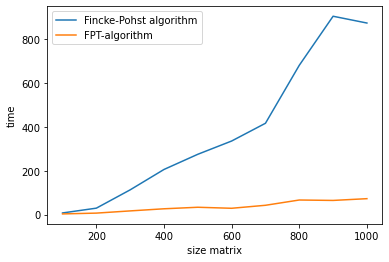

In [11]:
time_FinckePhost = get_time_from_file('LLL_time_det10.csv', 3)
time_FPT = get_time_from_file('FPT_time_det10.csv', 3)
list_of_sizes_matrix = list(range(100, 1001, 100))
print("determinant =", 10)
plot_timeline(list_of_sizes_matrix, [time_FinckePhost, time_FPT], ["Fincke-Pohst algorithm", "FPT-algorithm"])

determinant = 30


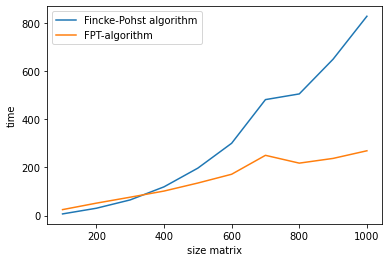

In [12]:
time_FinckePhost = get_time_from_file('LLL_time_det30.csv', 3)
time_FPT = get_time_from_file('FPT_time_det30.csv', 3)
list_of_sizes_matrix = list(range(100, 1001, 100))
print("determinant =", 30)
plot_timeline(list_of_sizes_matrix, [time_FinckePhost, time_FPT], ["Fincke-Pohst algorithm", "FPT-algorithm"])

determinant = 60


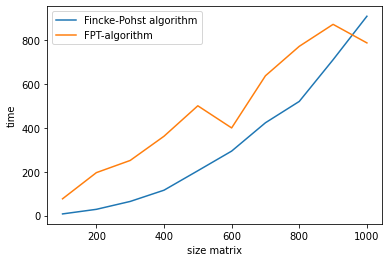

In [18]:
time_FinckePhost = get_time_from_file('LLL_time_det60.csv', 3)
time_FPT = get_time_from_file('FPT_time_det60.csv', 3)
list_of_sizes_matrix = list(range(100, 1001, 100))
print("determinant =", 60)
plot_timeline(list_of_sizes_matrix, [time_FinckePhost, time_FPT], ["Fincke-Pohst algorithm", "FPT-algorithm"])

determinant = 100


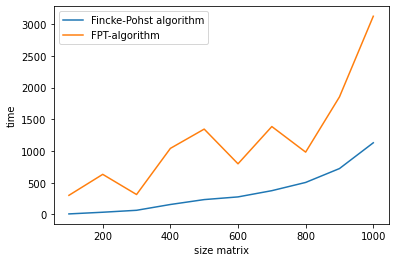

In [10]:
time_FinckePhost = get_time_from_file('LLL_time_det100.csv', 3)
time_FPT = get_time_from_file('FPT_time_det100.csv', 3)
list_of_sizes_matrix = list(range(100, 1001, 100))
print("determinant =", 100)
plot_timeline(list_of_sizes_matrix, [time_FinckePhost, time_FPT], ["Fincke-Pohst algorithm", "FPT-algorithm"])

In [8]:
list_matrix_det30_fplll = get_random_matrices("matrix_size250_det30.csv")

In [10]:
run_tests(list_matrix_det30_fplll, "LLL_time_det30_fplll.csv", "FPT_time_det30_fplll.csv", "fpLLL_time_det30_fplll.csv")


 Step  0 
 determinant = 30     size = 50
fplll_min = 1   FPT_min = 1

 Step  1 
 determinant = 30     size = 50
fplll_min = 1   FPT_min = 1

 Step  2 
 determinant = 30     size = 50
fplll_min = 1   FPT_min = 1

 Step  3 
 determinant = 30     size = 100
fplll_min = 1   FPT_min = 1

 Step  4 
 determinant = 30     size = 100
fplll_min = 1   FPT_min = 1

 Step  5 
 determinant = 30     size = 100
fplll_min = 1   FPT_min = 1

 Step  6 
 determinant = 30     size = 150
fplll_min = 1   FPT_min = 1

 Step  7 
 determinant = 30     size = 150
fplll_min = 1   FPT_min = 1

 Step  8 
 determinant = 30     size = 150
fplll_min = 1   FPT_min = 1

 Step  9 
 determinant = 30     size = 200
fplll_min = 1   FPT_min = 1

 Step  10 
 determinant = 30     size = 200
fplll_min = 1   FPT_min = 1

 Step  11 
 determinant = 30     size = 200
fplll_min = 1   FPT_min = 1

 Step  12 
 determinant = 30     size = 250
fplll_min = 1   FPT_min = 1

 Step  13 
 determinant = 30     size = 250
fplll_min = 1   FPT

determinant = 30


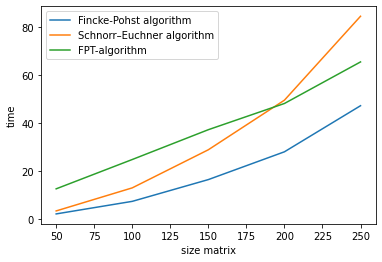

In [18]:
time_FinckePhost = get_time_from_file('LLL_time_det30_fplll.csv', 3)
time_FPT = get_time_from_file('FPT_time_det30_fplll.csv', 3)
time_fplll = get_time_from_file('fpLLL_time_det30_fplll.csv', 3)
list_of_sizes_matrix = list(range(50, 251, 50))
print("determinant =", 30)
plot_timeline(list_of_sizes_matrix, [time_FinckePhost, time_fplll, time_FPT], ["Fincke-Pohst algorithm", "Schnorr–Euchner algorithm", "FPT-algorithm"])

In [12]:
list_matrix_det100_fplll = get_random_matrices("matrix_size250_det100.csv")

In [13]:
run_tests(list_matrix_det100_fplll, "LLL_time_det100_fplll.csv", "FPT_time_det100_fplll.csv", "fpLLL_time_det100_fplll.csv")


 Step  0 
 determinant = 100     size = 50
fplll_min = 2   FPT_min = 2

 Step  1 
 determinant = 100     size = 50
fplll_min = 2   FPT_min = 2

 Step  2 
 determinant = 100     size = 50
fplll_min = 1   FPT_min = 1

 Step  3 
 determinant = 100     size = 100
fplll_min = 1   FPT_min = 1

 Step  4 
 determinant = 100     size = 100
fplll_min = 2   FPT_min = 2

 Step  5 
 determinant = 100     size = 100
fplll_min = 2   FPT_min = 2

 Step  6 
 determinant = 100     size = 150
fplll_min = 1   FPT_min = 1

 Step  7 
 determinant = 100     size = 150
fplll_min = 1   FPT_min = 1

 Step  8 
 determinant = 100     size = 150
fplll_min = 1   FPT_min = 1

 Step  9 
 determinant = 100     size = 200
fplll_min = 2   FPT_min = 2

 Step  10 
 determinant = 100     size = 200
fplll_min = 1   FPT_min = 1

 Step  11 
 determinant = 100     size = 200
fplll_min = 1   FPT_min = 1

 Step  12 
 determinant = 100     size = 250
fplll_min = 1   FPT_min = 1

 Step  13 
 determinant = 100     size = 250
fplll

determinant = 100


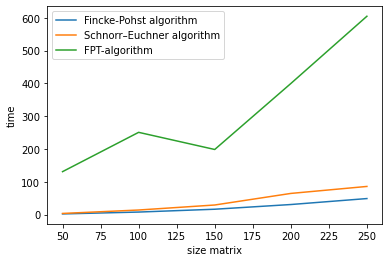

In [17]:
time_FinckePhost = get_time_from_file('LLL_time_det100_fplll.csv', 3)
time_FPT = get_time_from_file('FPT_time_det100_fplll.csv', 3)
time_fplll = get_time_from_file('fpLLL_time_det100_fplll.csv', 3)
list_of_sizes_matrix = list(range(50, 251, 50))
print("determinant =", 100)
plot_timeline(list_of_sizes_matrix, [time_FinckePhost, time_fplll, time_FPT], ["Fincke-Pohst algorithm", "Schnorr–Euchner algorithm", "FPT-algorithm"])

In [70]:
# dict_times = test_run_time(list_random_matrix_from_100, 2)


 Step  0 
 determinant = 50     size = 100
LLL_min = 1

 Step  1 
 determinant = 50     size = 100
LLL_min = 1

 Step  2 
 determinant = 50     size = 100
LLL_min = 1

 Step  3 
 determinant = 50     size = 100
LLL_min = 1

 Step  4 
 determinant = 50     size = 100
LLL_min = 1

 Step  5 
 determinant = 50     size = 150
LLL_min = 1

 Step  6 
 determinant = 50     size = 150
LLL_min = 1

 Step  7 
 determinant = 50     size = 150
LLL_min = 1

 Step  8 
 determinant = 50     size = 150
LLL_min = 1

 Step  9 
 determinant = 50     size = 150
LLL_min = 1

 Step  10 
 determinant = 50     size = 200
LLL_min = 1

 Step  11 
 determinant = 50     size = 200
LLL_min = 1

 Step  12 
 determinant = 50     size = 200
LLL_min = 1

 Step  13 
 determinant = 50     size = 200
LLL_min = 1

 Step  14 
 determinant = 50     size = 200
LLL_min = 1

 Step  15 
 determinant = 50     size = 250
LLL_min = 1

 Step  16 
 determinant = 50     size = 250
LLL_min = 1

 Step  17 
 determinant = 50     size = 

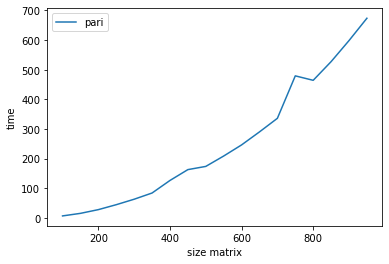

In [77]:
plot_timeline(list_of_sizes_matrix, [time_LLL], ["pari"])